## Algorithms comparaison with time limited

#### Initialisation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression

mnist_train = pd.read_csv("mnist_train.csv", header=None)
mnist_test = pd.read_csv("mnist_test.csv", header = None)
n,d = mnist_train.shape
ntest, dtest = mnist_test.shape


y_train = mnist_train.iloc[:,0]
X_train = mnist_train.iloc[:,1:]
X_train /= 255
X_train = np.array(X_train)

y_test = mnist_test.iloc[:,0]
X_test = mnist_test.iloc[:,1:]
X_test /= 255
X_test = np.array(X_test)


y_train = 2*np.array(y_train == 0)-1
y_test = 2*np.array(y_test == 0)-1

In [2]:
def hinge_reg_sgd(x, a, b, lamb):
    threshold = b*np.dot(a,x)[0]
    cost = np.maximum(1 - threshold,0)
    return cost + lamb*np.dot(x.T,x)/2

In [3]:
def grad_reg_sgd(x, a, b, lamb, d):
    threshold = b*np.dot(a,x)[0]

    if (threshold >= 1):
        grad = np.zeros(d)
    else:
        grad = -b*a

    return grad.reshape(d,) + lamb*x

In [4]:
def hingereg(x, a, b, lamb):
    threshold = np.multiply(np.dot(a,x), b) 
    cost = np.maximum(1 - threshold,0)
    return cost.mean() + lamb*np.dot(x.T,x)/2

In [5]:
def gradreg(x, a, b, lamb):
    n,d = a.shape
    threshold = np.multiply(np.dot(a,x) , b)
    grad = -np.multiply(a, b.reshape(b.shape[0],1))
    idx_zeros = (threshold >= 1)
    grad[idx_zeros,:] = np.zeros(d)
    return grad.sum(axis=0)/n + lamb*x

In [6]:
def sample_ball(dim):
    u = np.random.normal(0,1,dim)
    norm=np.sum(u**2) **(0.5)
    r = np.random.rand()**(1.0/dim)
    x = r*u/norm
    return x

In [7]:
def proj_l2(x, z=1):
    norm = np.sqrt(np.sum(x**2))
    if (norm > z):
        x /= (norm/z)
    return x

In [8]:
def proj_simplex(x, z=1):

    d = x.shape[0]
    x_sorted = -np.sort(-x) 
    x_cumsum = np.cumsum(x_sorted)
    find = x_sorted - (1/np.arange(1,d+1,1))*(x_cumsum - z)
    d0 = np.argmax(find <= 0) 
    theta_star = (1/d0)*(x_cumsum[d0-1] - z)

    return np.maximum(x-theta_star,0)


def proj_l1(x, z=1):
    x_abs = np.absolute(x)
    if (np.sum(x_abs) > z):
        p_simplex = proj_simplex(x_abs, z)
        sgn = 2*(x>0)-1
        x = np.multiply(sgn, p_simplex)    
    return x

In [9]:
def proj_l1_w(x,w,z=1):
    v = abs(x* w)
    u = np.argsort(-v)
  
    sx = np.cumsum(abs(x)[u])
    sw = np.cumsum(1/w[u])
    
    rho = np.argmax(v[u] - (sx-z) / sw <= 0) - 1
    theta = (sx[rho] -z) / sw[rho]
    
    x_simplex = np.maximum(abs(x) - theta/w, 0)
    x_abs = np.absolute(x)
    if (np.sum(x_abs) > z):
        sgn = np.sign(x)
        x = np.multiply(sgn, x_simplex)  
        
    return x

In [10]:
def oracle_l1(x,z=10):
    idx = np.argmax(np.abs(x))
    sign = np.sign(x[idx])
    res = np.zeros(784) 
    res[idx] = z*sign
    return res

#### Baseline algorithms

In [11]:
def GD(a, b, init, iters, cost,  grad, lamb, X_test = None, y_test = None):

    test_scores = []
    p=init
    
    i=1
    timeout = time.time() + time_ex
    while True:
        eta = lamb/np.sqrt(i+1) 
        p -= eta * grad(p, a, b, lamb)
        test_score = (np.multiply(np.matmul(X_test,p), y_test) > 0).mean() 
        test_scores.append(test_score)
        
        i += 1
        if time.time() > timeout:
            break
     
    
    print("Last test score for GD : {}".format(test_scores[-1]))
        
    return np.array(test_scores)

In [12]:
def projected_GD(a, b, init, iters, cost,  grad, lamb, X_test = None, y_test = None, z=10):

    test_scores = []
    p=init
    
    i=1
    timeout = time.time() + time_ex
    while True:
        eta = lamb/np.sqrt(i+1) 
        y = p - eta * grad(p, a, b, lamb)
        p = proj_l1(y, z)
        test_score = (np.multiply(np.matmul(X_test,p), y_test) > 0).mean() 
        test_scores.append(test_score)
        
        i += 1
        if time.time() > timeout:
            break
       
    
    print("Last test score for projected GD : {}".format(test_scores[-1]))
    
    return np.array(test_scores)

In [13]:
def ONS(a, b, iters, cost,  grad, lamb, X_test = None, y_test = None, z=10):

    start_time = time.time()
    n,d = a.shape
    
    indices = np.random.randint(0,n,iters)
    test_scores = []
    
    gamma = min(1, 1/(8*z)) # theorem
    eps = (1/((gamma**2)*(2*z)**2))
    
    xt = np.zeros(d)
    At = np.eye(d)*eps
    At_m1 = np.zeros((d,d))
    np.fill_diagonal(At_m1, 1/np.diag(At))
    p_mean = np.zeros(d)
    
    
    i=1
    timeout = time.time() + time_ex
    while True:
        
        # Random indice
        x_i = a[indices[i-1],:].reshape(1,d)
        y_i = b[indices[i-1]]
        
        # ONS update 
        grad_t = grad(xt, x_i, y_i, lamb, d)
        hess_hat = np.outer(grad_t, grad_t) 
        At += hess_hat       
        At_m1 -= (1/(1+grad_t.dot(At_m1).dot(grad_t)))*(At_m1.dot(hess_hat).dot(At_m1))
        yt = xt - (1/gamma)*np.dot(At_m1, grad_t)
        #xt = np.real(mat.sqrtm(At_m1*i).dot(proj_l1(mat.sqrtm(At/i).dot(yt), z)))
        xt = yt
        
        # Save
        p_mean += xt
        test_score = (np.multiply(np.matmul(X_test,p_mean/i), y_test) > 0).mean() 
        test_scores.append(test_score)
        
        i += 1
        if time.time() > timeout:
            break
    
    
    end_time = time.time()
    print("Time of execution : %s seconds" % (end_time - start_time)) 
    return np.array(test_scores)

#### New algorithms

In [14]:
def OSPF(a, b, init, iters, cost,  grad, oracle, X_test = None, y_test = None, z=0.75, k=5, delta=1, lamb = (1/3)):

    start_time = time.time()
    n,d = a.shape
    
    indices = np.random.randint(0,n,iters)
    test_scores = []
    grad_sum = np.zeros(d)
    x_mean = init
    x_t = init

    
    i=1
    timeout = time.time() + time_ex
    while True:
        delta = np.sqrt(1/i)
        
        if (i % k != 0):
            x_i = a[indices[i-1],:].reshape(1,d)
            y_i = b[indices[i-1]]
            grad_t = grad(x_t, x_i, y_i, lamb, d)
            grad_sum += grad_t
            
            x_mean += x_t
            test_score = (np.multiply(np.matmul(X_test,x_mean/i), y_test) > 0).mean() 
            test_scores.append(test_score)
            
            
        else:
            to_proj = [(1/delta)*sample_ball(d) -grad_sum for _ in range(k)]
            xj = np.array([oracle(x, z) for x in to_proj])
            x_t = np.mean(xj, axis=0)
            
            x_mean += x_t
            test_score = (np.multiply(np.matmul(X_test,x_mean/i), y_test) > 0).mean() 
            test_scores.append(test_score)
            
            
            x_i = a[indices[i-1],:].reshape(1,d)
            y_i = b[indices[i-1]]
            grad_t = grad(x_t, x_i, y_i, lamb, d)
            grad_sum += grad_t
        
        i += 1
        if time.time() > timeout:
            break
        
        
    
    end_time = time.time()
    print("Last test score for OSPF : {}".format(test_scores[-1]))
    return np.array(test_scores)

In [15]:
def SFPL_v2(a, b, iters, cost,  grad, oracle, X_test = None, y_test = None, z=10, delta=1, m = 25, lamb = (1/3)):

    n,d = a.shape
    
    indices = np.random.randint(0,n,iters)
    test_scores = []
    
    grad_sum = np.zeros(d)
    x_mean = np.zeros(d)
    x_t = np.zeros(d)

    i=1
    timeout = time.time() + time_ex
    while True:       
        # Learn
        delta, m = np.sqrt(1/i), int(1+lamb*z*np.sqrt(i))
        vjs = np.array([sample_ball(d) for _ in range(m)]) # shape = m x d
        xjs = np.array([oracle(-grad_sum+ (1/delta)*vjs[j], z) for j in range(m)]) 
        xt = np.mean(xjs, axis=0)
        x_mean += xt
        
        # Incur
        x_i = a[indices[i-1],:].reshape(1,d)
        y_i = b[indices[i-1]]
        grad_t = grad(xt, x_i, y_i, lamb, d)
        grad_sum += grad_t
            

        # Save
        test_score = (np.multiply(np.matmul(X_test,x_mean/i), y_test) > 0).mean() 
        test_scores.append(test_score)
        
        i += 1
        if time.time() > timeout:
            break
    
    
    print("Last test score for SFPL : {}".format(test_scores[-1]))
    return (x_mean/iters), np.array(test_scores)

#### Results

In [16]:
nb_min = 1
time_ex = 60*nb_min

def learn_and_plot():
    l = (1/3)
    niter=15000
    
    # Baselines    
    x0 = np.zeros(784) 
    test_scores_gd_proj = projected_GD(X_train, y_train, x0, iters=niter, cost = hingereg, grad = gradreg, lamb=(1/3), X_test=X_test, y_test=y_test)

    x0 = np.zeros(784) 
    test_scores_gd = GD(X_train, y_train, x0, iters=niter, cost = hingereg, grad = gradreg, lamb=(1/3), X_test=X_test, y_test=y_test)

    z=15
    x0 = np.zeros(784) 
    lamb=(1/3)
    test_scores_ons = ONS(X_train, y_train, niter, hinge_reg_sgd, grad_reg_sgd, lamb, X_test, y_test, z)
    
    # New algorithm
    x0 = np.zeros(784) 
    delta, k = np.sqrt(1/niter), 5
    lamb = (1/3)
    z=0.75
    test_scores_ospf = OSPF(X_train, y_train, x0, niter, hinge_reg_sgd, grad_reg_sgd, proj_l2, X_test, y_test, z, k, delta, lamb)

  
    # Plot
    plt.plot(np.log(range(1, 1+len(test_scores_ospf))), np.log(1-test_scores_ospf), label = "OSPF")
    plt.plot(np.log(range(1, 1+len(test_scores_gd))), np.log(1-test_scores_gd), label = "GD")
    plt.plot(np.log(range(1, 1+len(test_scores_gd_proj))), np.log(1-test_scores_gd_proj), label = "GD proj")
    plt.plot(np.log(range(1, 1+len(test_scores_ons))), np.log(1-test_scores_ons), label = "ONS")
    

    plt.xlabel("Iterations (log-scale)")
    plt.ylabel("Test loss (log-scale)")
    plt.legend()
    plt.show()

Last test score for projected GD : 0.979
Last test score for GD : 0.979
Time of execution : 60.05183458328247 seconds
Last test score for OSPF : 0.9773


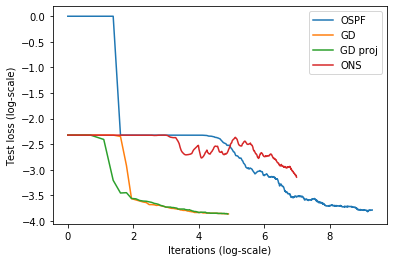

In [17]:
learn_and_plot()